# Part I. EDA

## В этом разделе был проведен анализ изображений, собраны и проанализированы различные features для последующего использования.

# Features

1. Image size
2. Channel intensities
        2.1 Averages:
        * Average of red-channel intensity
        * Average of green-channel intensity
        * Average of blue-channel intensity
        2.2 Standard deviations:
        * Standard deviation of red-channel intensity
        * Standard deviation of green-channel intensity
        * Standard deviation of blue-channel intensity
3. Aspect-ratio
4. Average gray-scale intensity
5. HOG
        * Standard deviation
        * Mean
6. Channel stride averages
7. Flattened RGB 3D-Histogram
8. Count of Harris Corners
9. Mean of Harris Corner response map
10. Circle-count using Hough Transform
11. SIFT - Scale Invariant Feature Transform

In [ ]:
import os
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
import cv2
from skimage.feature import hog
from PIL import Image, ImageChops
def data_dictionary():
    path_train = "/home/roman/roman/code/git/EDU/HSE/_data/year_project/dermnet/train/"
    train_data_categories = os.listdir(path_train)
    list_train = train_data_categories
    train_dictionary = {"image_path": [], "target": [], "Label": []}#, "Image": []}
    k = 0   
    for i in tqdm(list_train):
        path_train_item = path_train + "/" + i
        image_list_train = os.listdir(path_train_item)
        for j in image_list_train:
            img_path_train = path_train_item + "/" + j
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(k)
            train_dictionary['Label'].append(i)
            #train_dictionary['Image'].append(io.imread(img_path_train))
        k += 1        
    return pd.DataFrame(train_dictionary)



df = data_dictionary()
print(f"df = {df}")

In [7]:
import os
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
import cv2
from skimage.feature import hog
from PIL import Image, ImageChops
def data_dictionary():
    path_train = "/home/roman/roman/code/git/EDU/HSE/_data/year_project/dermnet/train/"
    train_data_categories = os.listdir(path_train)
    list_train = train_data_categories
    train_dictionary = {"image_path": [], "target": [], "Label": []}#, "Image": []}
    k = 0   
    for i in tqdm(list_train):
        path_train_item = path_train + "/" + i
        image_list_train = os.listdir(path_train_item)
        for j in image_list_train:
            img_path_train = path_train_item + "/" + j
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(k)
            train_dictionary['Label'].append(i)
            #train_dictionary['Image'].append(io.imread(img_path_train))
        k += 1        
    return pd.DataFrame(train_dictionary)



df = data_dictionary()
print(f"df = {df}")

100%|██████████| 23/23 [00:06<00:00,  3.40it/s]

df =                                               image_path  target  \
0      /kaggle/input/dermnet/train//Light Diseases an...       0   
1      /kaggle/input/dermnet/train//Light Diseases an...       0   
2      /kaggle/input/dermnet/train//Light Diseases an...       0   
3      /kaggle/input/dermnet/train//Light Diseases an...       0   
4      /kaggle/input/dermnet/train//Light Diseases an...       0   
...                                                  ...     ...   
15552  /kaggle/input/dermnet/train//Warts Molluscum a...      22   
15553  /kaggle/input/dermnet/train//Warts Molluscum a...      22   
15554  /kaggle/input/dermnet/train//Warts Molluscum a...      22   
15555  /kaggle/input/dermnet/train//Warts Molluscum a...      22   
15556  /kaggle/input/dermnet/train//Warts Molluscum a...      22   

                                              Label  
0      Light Diseases and Disorders of Pigmentation  
1      Light Diseases and Disorders of Pigmentation  
2      Light Dis

Создать распределение по количеству картинок

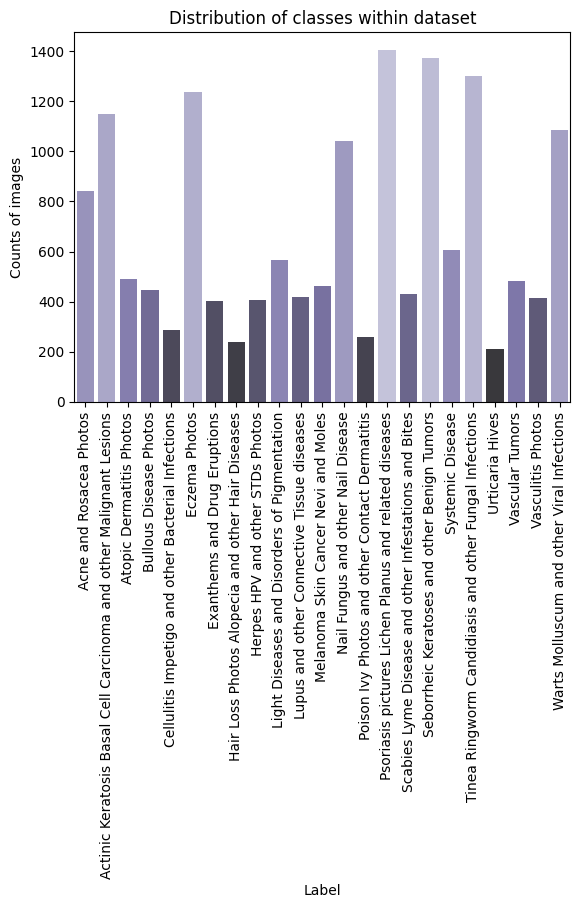

In [8]:
def create_bar_plot_with_counts(df):
    labels = df.groupby("Label")["image_path"].count()
    pal = sns.color_palette("Purples_d", len(labels))
    rank = labels.argsort().argsort()
    sns.barplot(x=labels.index, y=labels.values, palette=np.array(pal[::-1])[rank])
    plt.title("Distribution of classes within dataset")
    plt.ylabel("Counts of images")
    plt.xticks(rotation=90)
    plt.show()
    
create_bar_plot_with_counts(df)

Распределение по каналам

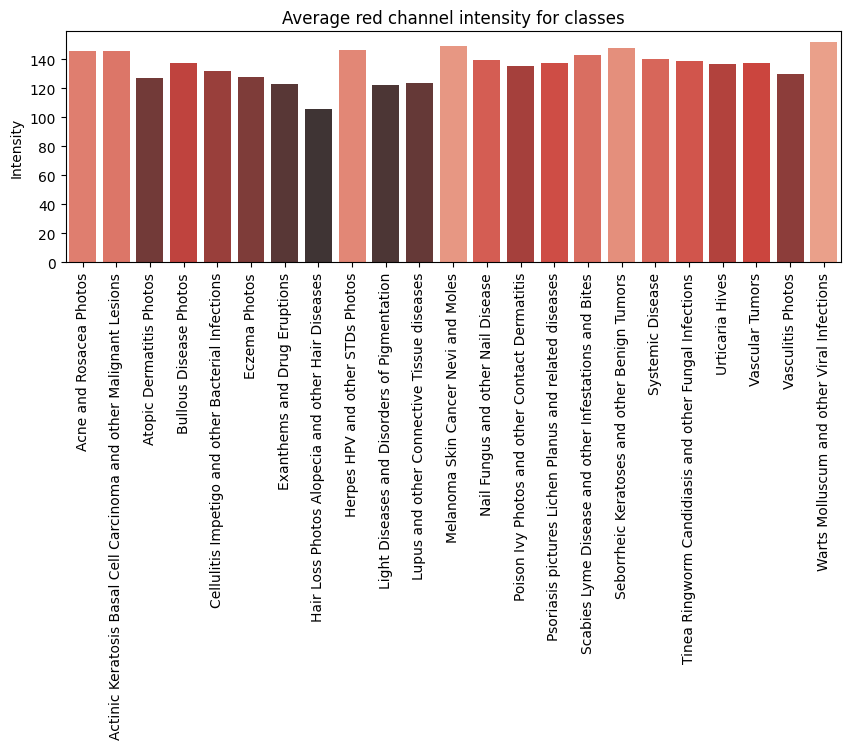

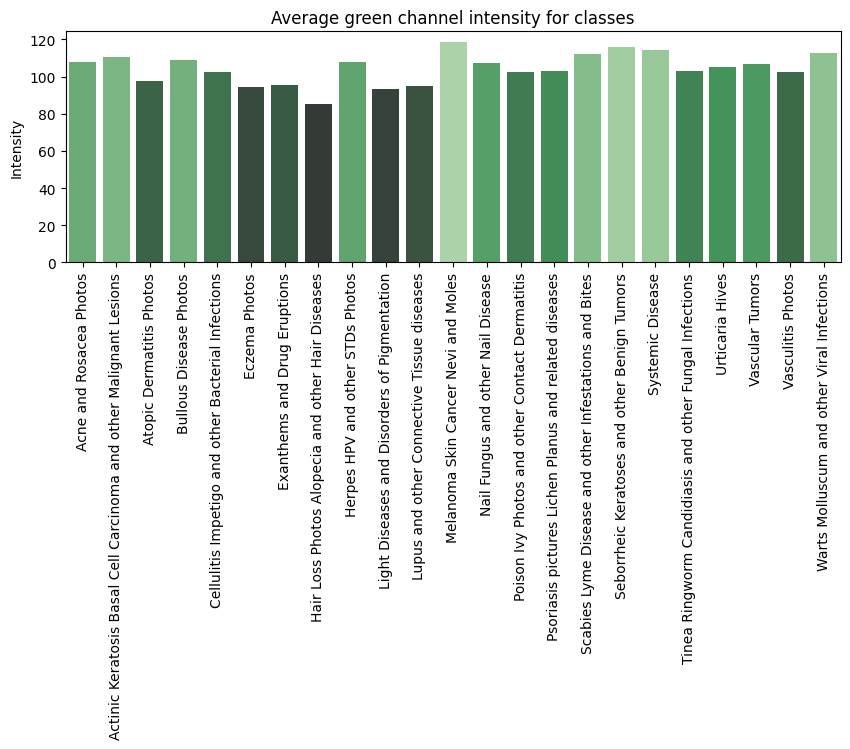

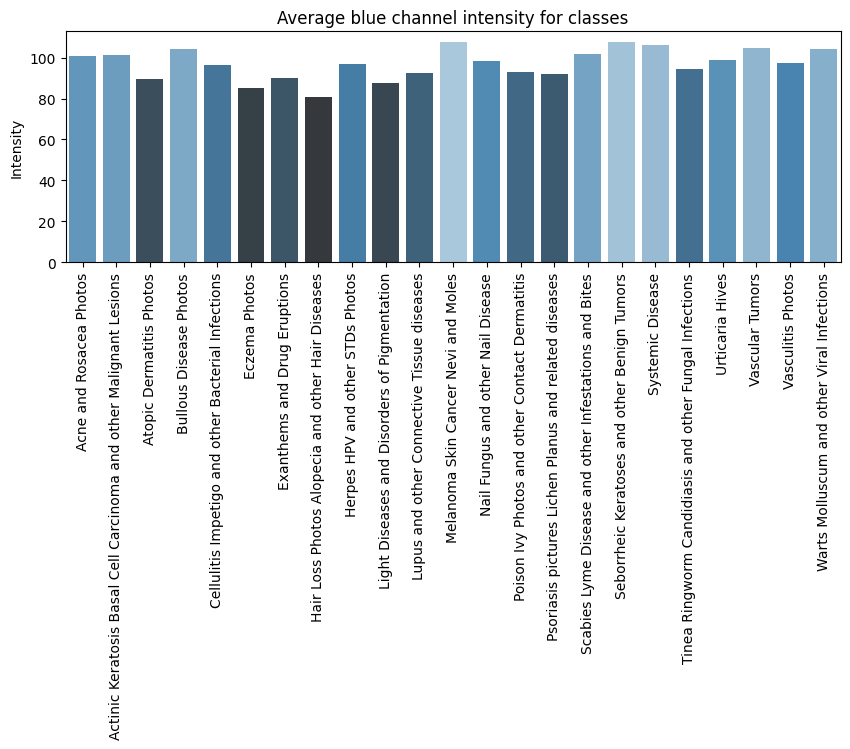

In [9]:
def calculate_channel_average(img, channel):
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in img]).flatten()
    return np.mean(channel_intensities)

def plot_channel_intensity_barplot(df, channel):
    title_dict = {"r": "red", "g": "green", "b": "blue"}
    palet_dict = {"r": "Reds_d", "g": "Greens_d", "b": "Blues_d"}
    plt.figure(figsize=(10, 3))

    values = df["image_path"].values
    pal = sns.color_palette(palet_dict[channel], len(values))
    rank = values.argsort().argsort()
    sns.barplot(x=df["Label"].values, y=values, palette=np.array(pal[::-1])[rank])
    plt.ylabel("Intensity")
    plt.title(f"Average {title_dict[channel]} channel intensity for classes")
    plt.xticks(rotation=90)
    plt.show()
    
red_channel_average = df.groupby("Label").agg({"image_path": lambda s: np.mean(
    [calculate_channel_average(io.imread(img), channel="R") for img in s])}).reset_index()
green_channel_average = df.groupby("Label").agg({"image_path": lambda s: np.mean(
    [calculate_channel_average(io.imread(img), channel="G") for img in s])}).reset_index()
blue_channel_average = df.groupby("Label").agg({"image_path": lambda s: np.mean(
    [calculate_channel_average(io.imread(img), channel="B") for img in s])}).reset_index()

plot_channel_intensity_barplot(red_channel_average, "r")
plot_channel_intensity_barplot(green_channel_average, "g")
plot_channel_intensity_barplot(blue_channel_average, "b")

Совокупный отчет по каналам

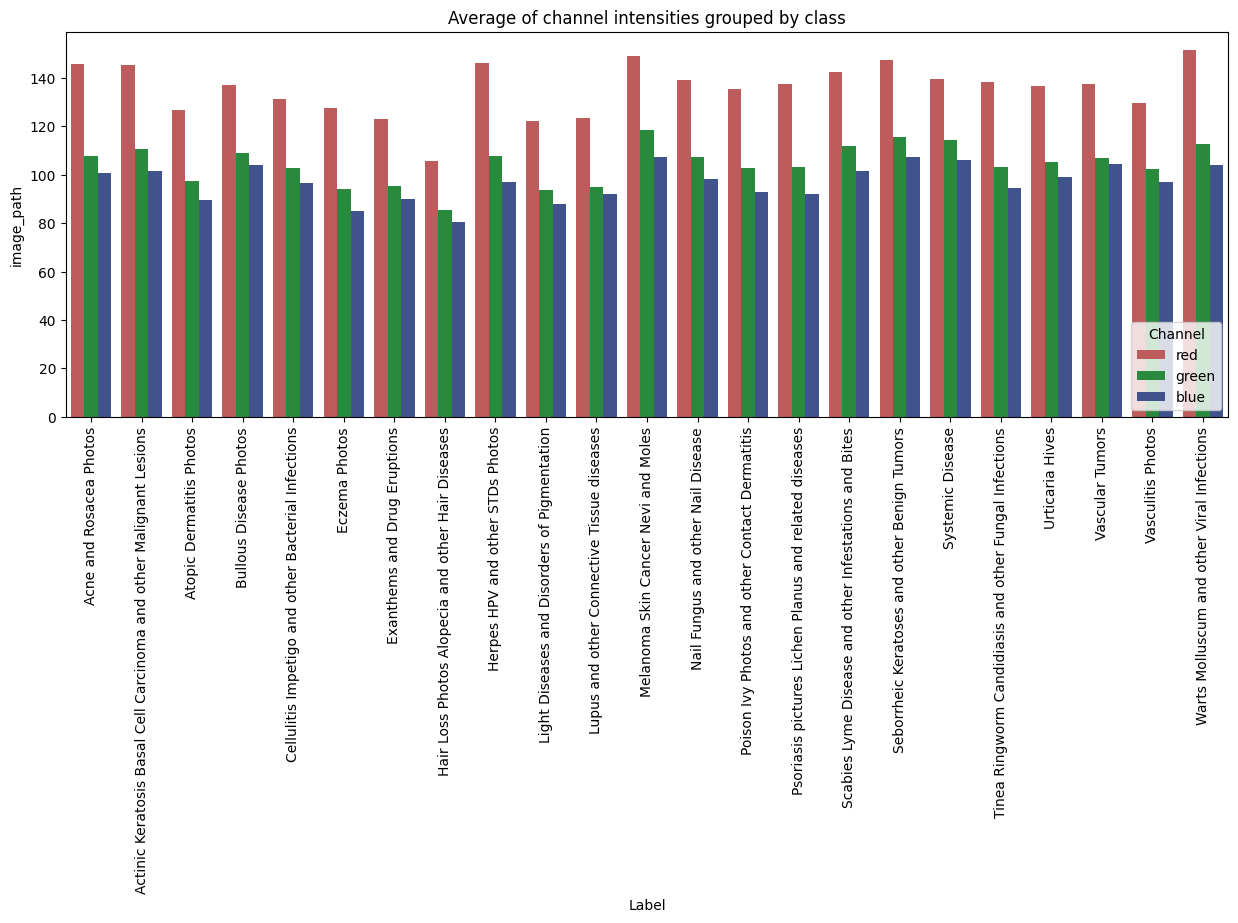

In [10]:
def set_type_array(channel,df):
    df["type"] = [channel for _ in range(len(df))]


def create_concatenated_plot(channel_averages):
    plt.figure(figsize=(15, 5))
    colors = [[0.8, 0.3, 0.3], [0.1, 0.6, 0.2], [0.2, 0.3, 0.6]]
    ax = sns.barplot(x=channel_averages["Label"].values, y="image_path", hue="type",
                     data=channel_averages, palette=colors)
    plt.xlabel("Label")
    plt.title("Average of channel intensities grouped by class")
    ax.legend(title="Channel", loc="lower right")
    plt.xticks(rotation=90)
    plt.show()

set_type_array("red", red_channel_average)
set_type_array("green", green_channel_average)
set_type_array("blue", blue_channel_average)

channel_averages = pd.concat([red_channel_average, green_channel_average, blue_channel_average])

create_concatenated_plot(channel_averages)

Распределение размеров картинок

15557it [01:44, 148.42it/s]


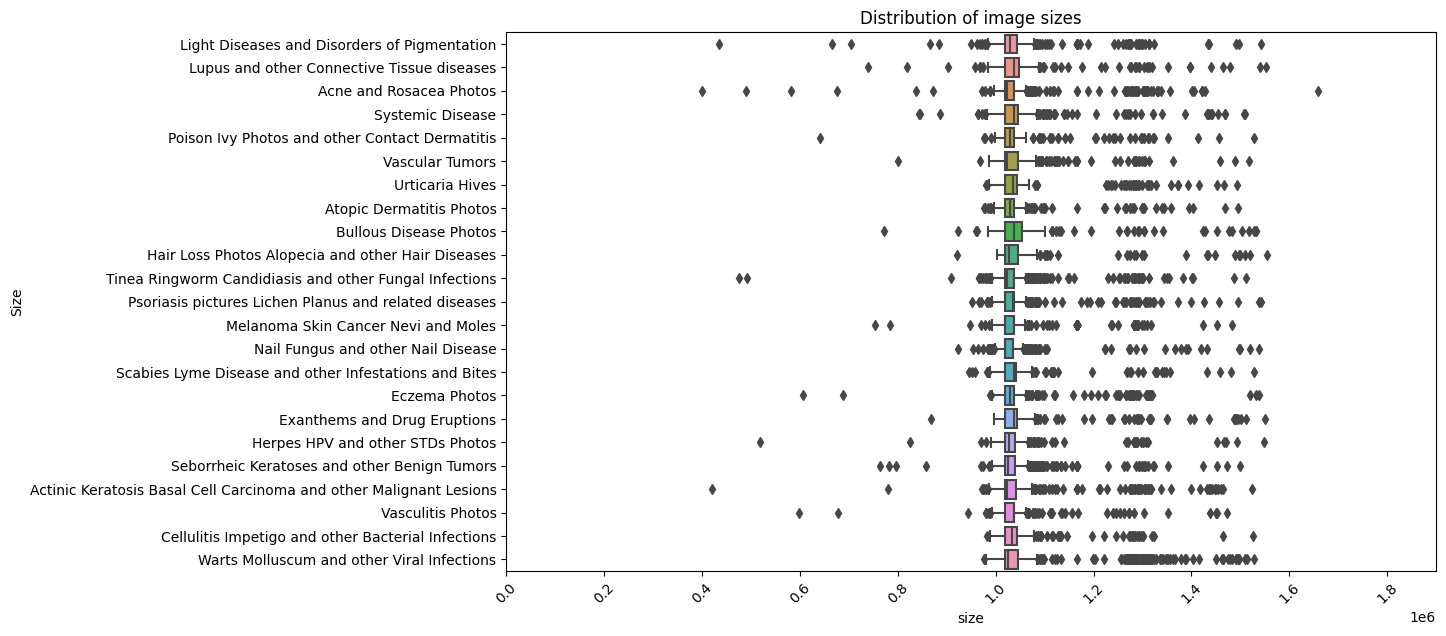

In [11]:
def create_distribution_image_size(df):
    plt.figure(figsize=(12, 7))
    sns.boxplot(y=df["Label"].values, x="size", data=df, orient="h")
    plt.title("Distribution of image sizes")
    plt.xticks(np.arange(0, 1900000, 200000), rotation=45)
    plt.xlim(0, 1900000)
    plt.ylabel("Label");
    plt.ylabel("Size");
    plt.show()


df['size'] = None
for index, row in tqdm(df.iterrows()):    
    df.at[index, 'size'] = np.size(io.imread(row["image_path"]))
    
create_distribution_image_size(df)

Preprocessing, распределение ширины и высоты в картинках

15557it [01:47, 145.15it/s]


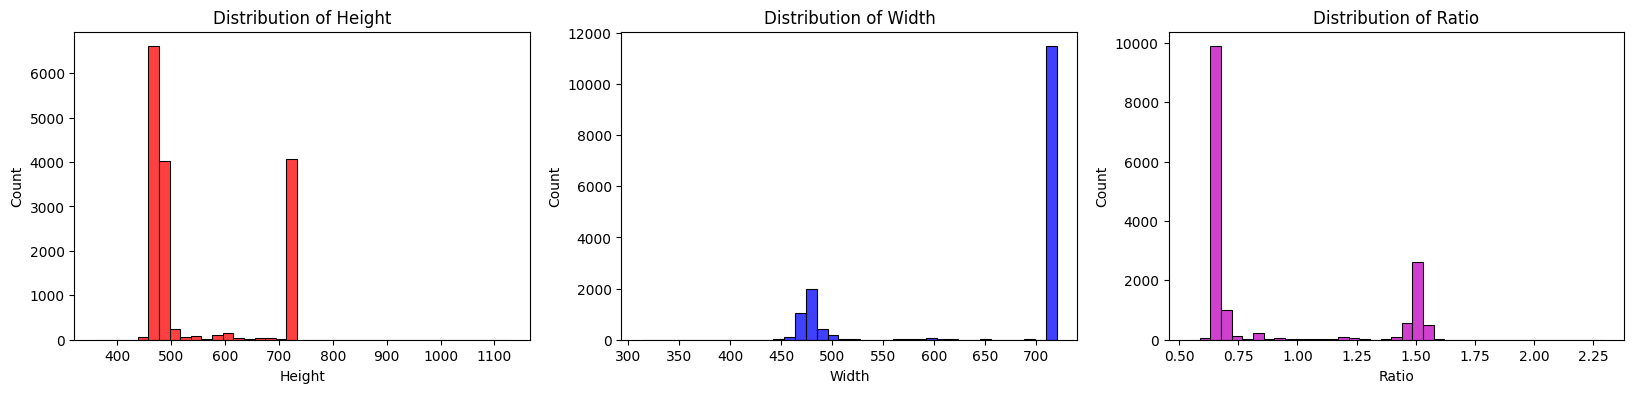

In [12]:
def get_trimmed_image(image):
    """
    Returns image without white border if such border exists.
    If not, returns original image
    """
    imagePIL = Image.fromarray(np.array(image))
    bg = Image.new(imagePIL.mode, imagePIL.size, imagePIL.getpixel((0,0)))
    diff = ImageChops.difference(imagePIL, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        trimmed_img = imagePIL.crop(bbox)
        return np.array(trimmed_img)
    return image


def resize_image(image, size):
    return cv2.resize(image, size, interpolation = cv2.INTER_AREA)


def create_plot_width_height_distribution(df):
    df['height'] = None
    df['width'] = None
    df['ratio'] = None
    for index, row in tqdm(df.iterrows()):   
        image = io.imread(row["image_path"])
        df.at[index, 'height'] = len(image)
        df.at[index, 'width'] = len(image[0])
        df.at[index, 'ratio'] = len(image)/len(image[0])
      
    
    f, axes = plt.subplots(figsize=(20,4), ncols=3, nrows=1)
    sns.histplot(df['height'], ax=axes[0], color="r")
    sns.histplot(df['width'],  ax=axes[1], color="b")
    sns.histplot(df['ratio'],  ax=axes[2], color="m")
    axes[0].set_xlabel("Height")
    axes[1].set_xlabel("Width")
    axes[2].set_xlabel("Ratio")
    axes[0].title.set_text('Distribution of Height')
    axes[1].title.set_text('Distribution of Width')
    axes[2].title.set_text('Distribution of Ratio')    

    plt.show()
create_plot_width_height_distribution(df)

Функции анализа цветов

In [ ]:
def image_size(image):
    """
    Returns the pixel size of the image
    """
    return image.size
def grayscale_intensity(image):
    """
    Calculating the average grayscale intensity for all pixels given an image
    """
    grayscaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(grayscaled_image)

def aspectratio(image):
    """
    Returns the aspect ratio of the image (width/height)
    """
    return len(image[0])/len(image)
def standard_deviation_channel_intensity(image, channel):
    """
    Returning the average channel intensity (R, G or B) of an image
    """
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in image]).flatten()
    return np.std(channel_intensities)

def average_channel_intensity(image, channel):
    """
    Returning the average channel intensity (R, G or B) of an image
    """
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in image]).flatten()
    return np.mean(channel_intensities)

df['Size'] = None
df['AspectRatio'] = None
df['Red_intensity'] = None
df['Green_intensity'] = None
df['Blue_intensity'] = None
df['Std_Red_intensity'] = None
df['Std_Green_intensity'] = None
df['Std_Blue_intensity'] = None
df['Grayscale_intensity'] = None

scale_height = np.mean(df['height'])
mean_ratio = np.mean(df['ratio'])
scale_width = scale_height * mean_ratio
scaling_size = (int(scale_width), int(scale_height))

print(f"Rescaling to h: {scale_height}, w: {scale_width}")

for index, row in tqdm(df.iterrows()):   
        image = io.imread(row["image_path"])

        df['Size'] = image_size(image)
        df['AspectRatio'] = aspectratio(image)
        
        scaled_image = resize_image(image,scaling_size)
        
        df['Red_intensity'] = average_channel_intensity(scaled_image, 'R')
        df['Green_intensity'] = average_channel_intensity(scaled_image, 'G')
        df['Blue_intensity'] = average_channel_intensity(scaled_image, 'B')
        df['Std_Red_intensity'] = standard_deviation_channel_intensity(scaled_image, 'R')
        df['Std_Green_intensity'] = standard_deviation_channel_intensity(scaled_image, 'G')
        df['Std_Blue_intensity'] = standard_deviation_channel_intensity(scaled_image, 'B')
        df['Grayscale_intensity'] = grayscale_intensity(scaled_image)        

HOG

In [ ]:
def get_hog_features(image):
    """
    Gets the histogram of oriented gradients for an image
    """
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    return fd
def get_hog_mean(img):
    """
    Gets the mean of the HOG response map
    """
    fd = get_hog_features(img)
    return np.mean(fd) if len(fd) else 0
    
def get_hog_std(img):
    """
    Gets the standard deviation of the HOG response map
    """
    fd = get_hog_features(img)
    return np.std(fd) if len(fd) else 0

def create_hog_histogram(df):  
    f, axes = plt.subplots(figsize=(20, 10), ncols=2, nrows=1)
    sns.boxplot(y=df["Label"].values, x="HOG_mean", data=df, orient="h", ax=axes[0])
    sns.boxplot(y=df["Label"].values, x="HOG_std", data=df, orient="h", ax=axes[1])
    axes[0].set_xlim(0.28, 0.36)
    axes[0].title.set_text("Distribution of HOG descriptor mean")
    axes[1].title.set_text("Distribution of HOG descriptor standard deviation")
    axes[0].set_xlabel("HOG Mean")
    axes[1].set_xlabel("HOG Standard Devioation")
    plt.show()

for index, row in tqdm(df.iterrows()):   
        image = io.imread(row["image_path"])
        df['HOG_mean'] = get_hog_mean(image)
        df['HOG_std'] = get_hog_std(image)        

create_hog_histogram(df)

Создать распределение количества кругов в картинке

In [ ]:
def find_hough_circles(image, retry=False):
    """
    Finding the Hough Circles in a given image
    """
    try:
        img = image.copy()
        
        if retry:
            img = img.astype('uint8')
        
        img = cv2.medianBlur(img, 9)
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Finding circles using Hough Transform
        circles = cv2.HoughCircles(gray_img,
                                   cv2.HOUGH_GRADIENT,
                                   dp=1,
                                   minDist=40,
                                   param1=30,
                                   param2=50,
                                   minRadius=0,
                                   maxRadius=130)
        
    except:
        # Retry when it has to be changed to type uint8, which is only for augmented images
        circles = find_hough_circles(image, retry=True)
    
    return circles if circles is not None else np.array([[[]]])
    
def count_hough_circles(image):
    """
    Returning the number of Hough Circles in the input image
    """
    return find_hough_circles(image).shape[1]

def create_hist_circles(df):    
    for index, row in tqdm(df.iterrows()):   
        image = io.imread(row["image_path"])
        df['Circle_Count'] = count_hough_circles(image)
    plt.figure(figsize=(12,7))
    ax = sns.boxplot(y=df["Label"].values, x="Circle_Count", data=df, orient="h")
    ax.set_xlim(-10, 155);
    plt.show()

df['Circle_Count'] = None
create_hist_circles(df)

Harris Corner 

In [ ]:
def get_harris_corners_coordinates(img):
    """
    Returns a matrix containing the Harris Corners of an image. Coordinates mostly used for visualizing.
    """
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    corners = cv2.goodFeaturesToTrack(gray, 200, 0.75, 100)
    return np.int0(corners) if corners is not None else np.array([])


def get_harris_corners_count(img):
    """
    Returns the number of Harris Corners in a given image
    """
    return len(get_harris_corners_coordinates(img))


def visualize_harris_corners(img):
    """
    Visualize the harris corners of an image
    """
    image = img.copy()
    corners = get_harris_corners_coordinates(image)
    for i in corners:
        x,y = i.ravel()
        cv2.circle(image, (x, y), 3, (255, 0, 200), -1)
    
    plt.axis('off')
    plt.imshow(image)
    plt.show();

    
def get_harris_corner_mean(img):
    """
    Returns the mean of the non-zero harris corners. 
    The Harris Corners are found at the local maximas of the corners response map
    """
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    corners = np.where(corners > 0)
    return np.mean(corners)

df["Harris_Corner_Count"] = None
df["Harris_Corner_Mean"] = None

for index, row in df.iterrows():   
        image = io.imread(row["image_path"])
        df["Harris_Corner_Count"] = get_harris_corners_count(image)
        df["Harris_Corner_Mean"] = get_harris_corner_mean(image)
        
        
def create_harris_corner_hist(df):
    # Visualizing count of corner in images among classes
    f, axes = plt.subplots(figsize=(20, 10), ncols=2, nrows=1)
    sns.boxplot(y=df["Label"].values, x="Harris_Corner_Count", data=df, orient="h", ax=axes[0])
    sns.boxplot(y=df["Label"].values, x="Harris_Corner_Mean", data=df, orient="h", ax=axes[1]);
    axes[0].set_xlim(0, 12.5)
    axes[1].set_xlim(0, 750)
    axes[0].title.set_text("Distritbution of Harris corner count")
    axes[1].title.set_text("Distritbution of mean Harris corner significance")
    axes[0].set_xlabel("# of Harris corners")
    axes[1].set_xlabel("Mean of harris corner response map")
    plt.show()

create_harris_corner_hist(df)

SIFT

In [ ]:
a = df[df['Label']=='Acne and Rosacea Photos']['image_path']
img = io.imread(df["image_path"][1029])
img

In [ ]:
df[df['image_path'].str.contains('acne-closed-comedo-003.jpg', na=False)]

In [ ]:
plt.figure(figsize=(12,7))

def visualize_keypoints(image):
    """
    Visualizing SIFT keypoints of image with orientation
    """
    img = image.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    img2 = cv2.drawKeypoints(img, kp,  outImage=np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.imshow(img2)
    plt.axis("off");

img = io.imread(df["image_path"][1029])
visualize_keypoints(img)

In [ ]:
plt.figure(figsize=(15,10))

img1, img2 = io.imread(df["image_path"][1018]), io.imread(df["image_path"][1153])


sift = cv2.SIFT_create()
gray1, gray2 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# BFMatcher with default params
bf = cv2.BFMatcher()

matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.86*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, flags=2, outImg=np.array([]))

plt.imshow(img3)
plt.axis('off')
plt.show();

SIFT Descriptors

In [ ]:
def get_descriptors(img, sift=None):
    """
    Returns the SIFT descriptor of an given image
    """
    sift = sift if sift else cv2.SIFT_create()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp, descriptors = sift.detectAndCompute(gray, None)
    
    return np.array(descriptors) if descriptors is not None else np.array([])

scale_height = np.mean(df['height'])
mean_ratio = np.mean(df['ratio'])
scale_width = scale_height * mean_ratio
scaling_size = (int(scale_width), int(scale_height))

img = resize_image(io.imread(df["image_path"][1018]), scaling_size).copy()
descs = get_descriptors(img)
print(f"Shape of descriptors: {descs.shape}")

In [ ]:
def get_all_descriptors(images, labels, images_ids):    
    """
    Method that collects all descriptors from a series of images and puts them in a dataframe with 128 columns
    Also collecting labels for future plotting 
    """
    images = images.values
    start_time = timer()
    descriptor_matrix = []
    desc_labels = []
    desc_images_id = []
    sift = cv2.SIFT_create()
    print(f"\t- Processing {len(images)} images")
    for i, img in enumerate(images):
        descriptors = get_descriptors(img, sift)
        label = labels.iloc[i] if labels is not None else None
        image_id = images_ids.iloc[i]

        if len(descriptors) != 0:
            desc_labels.extend([label]*len(descriptors))
            descriptor_matrix.append(descriptors)
            desc_images_id.extend([image_id]*len(descriptors))
        print(f"[{((i + 1)/len(images))*100:.1f}%] Processed {i + 1} images. Time elapsed: {timer() - start_time:.1f} s", end='\r')
    
    descriptor_df = pd.DataFrame(np.concatenate(descriptor_matrix))
    descriptor_df['Image_Id'] = np.array(desc_images_id)
    descriptor_df['Label'] = np.array(desc_labels)

    return descriptor_df

In [ ]:
# Making a dataframe of all descriptors from all images 
# Adding ImageId and label for each descriptor so that we can extract them later, without having to compute them again

def find_and_save_descriptors_to_file(train_data=None):
    """
    Finds and saves all descriptors of images in training dataframe.
    Remark: Only used once
    """
    train_descriptor_df, test_descriptor_df = None, None
    
    if train_data is not None:
        print("\t- Creating descriptors for training data:")
        ids, labels, images =  df['Image_Id'], df['Label'], df['Image']
        train_descriptor_df = get_all_descriptors(images, labels, ids)
        train_descriptor_df.to_csv('descriptors_train.csv', index=False)
        
    return train_descriptor_df

In [ ]:
# Saving all descriptors from all images in training data to file 
# Later, when we split in training and test data, we locate the discriptors images by their image Id
# Only descriptors from training images will be used in the training
# Keep create_descriptor_files equals to False if you do not want to regenerate descriptor file
create_descriptor_files = False
if create_descriptor_files:
    find_and_save_descriptors_to_file(df)

# Part II. Classic ML

## В этом разделе будут использоваться различные модели классического МЛ - регрессии, деревья.
## Сразу стоит отметить, что каждый участник команды самостоятельно использовал features и работал с данными для обучения моделей. 

### Результаты

* #### CatBoost
>Accuracy - 0.25

>ROC_AUC - 0.69

* #### Random Forest
>Accuracy - 0.15

>ROC_AUC - 0.69

* #### Logistic Regression
>Accuracy - 0.10

>ROC_AUC - 0.55


## 1. Логистическая регрессия

In [1]:
import os
import numpy as np
import pandas as pd

from torchvision.transforms import v2
from sklearn.decomposition import PCA
from PIL import Image, ImageOps
import albumentations as A

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

**Предобработка изображений**

In [2]:
def load_images(data='train', pca_components=100):
    path = f"../input/dermnet/{data}/"
    list_cat = os.listdir(path)
    
    X, y = ([], [])
    
    transform = A.Compose([
    A.Rotate(limit=180, border_mode=0, p=1.0),
    A.GaussNoise(var_limit=(10, 30), p=0.5), 
    A.RandomBrightnessContrast(brightness_limit=0.25, p=0.25)
    ])
    
    for i, cat in enumerate(list_cat):  
        print(f'{i}: {cat}')
        list_images = os.listdir(path + cat)
        
        for j in list_images:   
            with Image.open(path + cat + "/" + j) as img:
                # приводим изображения к чёрно-белому формату и одному размеру
                img = np.array(v2.Resize(size=(256, 256))(ImageOps.grayscale(img)))
                
                for p in range(3): 
                    # применяем аугментации 2 раза 
                    if p:
                        img = transform(image=img)["image"]
                    
                    # применяем PCA с pca_components главными компонентами
                    pca = PCA(pca_components)
                    img_pca = pca.fit_transform(img)
                
                    # вытягиваем в одномерный массив и добавляем в матрицу объекты-признаки
                    X.append(img_pca.flatten())
                    y.append(i)
    
    return np.array(X), np.array(y)


X_train, y_train = load_images(data='train', pca_components=75)
X_test, y_test = load_images(data='test', pca_components=75)

0: Light Diseases and Disorders of Pigmentation
1: Lupus and other Connective Tissue diseases
2: Acne and Rosacea Photos
3: Systemic Disease
4: Poison Ivy Photos and other Contact Dermatitis
5: Vascular Tumors
6: Urticaria Hives
7: Atopic Dermatitis Photos
8: Bullous Disease Photos
9: Hair Loss Photos Alopecia and other Hair Diseases
10: Tinea Ringworm Candidiasis and other Fungal Infections
11: Psoriasis pictures Lichen Planus and related diseases
12: Melanoma Skin Cancer Nevi and Moles
13: Nail Fungus and other Nail Disease
14: Scabies Lyme Disease and other Infestations and Bites
15: Eczema Photos
16: Exanthems and Drug Eruptions
17: Herpes HPV and other STDs Photos
18: Seborrheic Keratoses and other Benign Tumors
19: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
20: Vasculitis Photos
21: Cellulitis Impetigo and other Bacterial Infections
22: Warts Molluscum and other Viral Infections
0: Light Diseases and Disorders of Pigmentation
1: Lupus and other Connective 

**Обучение моделей**

In [3]:
from sklearn.linear_model import LogisticRegression

# обучение модели
clf = LogisticRegression(tol=1e-4, max_iter=2500, random_state=123)
print(f'Fitting of LogisticRegression has started...')
clf.fit(X_train, y_train)
print(f'Fitting of LogisticRegression has finished!')

Fitting of LogisticRegression has started...
Fitting of LogisticRegression has finished!


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
# предикты
y_pred_test = clf.predict(X_test)
y_pred_proba_test = clf.predict_proba(X_test)

In [6]:
# результаты на тесте
print(f'Metrics of RandomForest on test: ')
print(f'   accuracy_avg  - {accuracy_score(y_test, y_pred_test):.2f}')
print(f'   precision_avg - {precision_score(y_test, y_pred_test, average="micro"):.2f}')
print(f'   reсall_avg    - {recall_score(y_test, y_pred_test, average="micro"):.2f}')
print(f'   roc_auc_avg   - {roc_auc_score(y_test, y_pred_proba_test, multi_class="ovr", average="micro"):.2f}')

Metrics of RandomForest on test: 
   accuracy_avg  - 0.10
   precision_avg - 0.10
   reсall_avg    - 0.10
   roc_auc_avg   - 0.55


In [7]:
import pickle 

# сохраняем модель в pickle файл
pickle.dump(clf, open('/kaggle/working/logreg_clf.pkl', 'wb'))
print(f'\nModel is dumped!')


Model is dumped!


## 2. Cлучайный лес

In [1]:
import os
import numpy as np
import pandas as pd

from torchvision.transforms import v2
from sklearn.decomposition import PCA
from PIL import Image, ImageOps
import albumentations as A

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

**Предобработка изображений**

In [2]:
def load_images(data='train', pca_components=100):
    path = f"../input/dermnet/{data}/"
    list_cat = os.listdir(path)
    
    X, y = ([], [])
    
    transform = A.Compose([
    A.Rotate(limit=180, border_mode=0, p=1.0),
    A.GaussNoise(var_limit=(10, 30), p=0.5), 
    A.RandomBrightnessContrast(brightness_limit=0.25, p=0.25)
    ])
    
    for i, cat in enumerate(list_cat):  
        print(f'{i}: {cat}')
        list_images = os.listdir(path + cat)
        
        for j in list_images:   
            with Image.open(path + cat + "/" + j) as img:
                # приводим изображения к чёрно-белому формату и одному размеру
                img = np.array(v2.Resize(size=(256, 256))(ImageOps.grayscale(img)))
                
                for p in range(3): 
                    # применяем аугментации 4 раза 
                    if p:
                        img = transform(image=img)["image"]
                    
                    # применяем PCA с pca_components главными компонентами
                    pca = PCA(pca_components)
                    img_pca = pca.fit_transform(img)
                
                    # вытягиваем в одномерный массив и добавляем в матрицу объекты-признаки
                    X.append(img_pca.flatten())
                    y.append(i)
    
    return np.array(X), np.array(y)


X_train, y_train = load_images(data='train', pca_components=75)
X_test, y_test = load_images(data='test', pca_components=75)

0: Light Diseases and Disorders of Pigmentation
1: Lupus and other Connective Tissue diseases
2: Acne and Rosacea Photos
3: Systemic Disease
4: Poison Ivy Photos and other Contact Dermatitis
5: Vascular Tumors
6: Urticaria Hives
7: Atopic Dermatitis Photos
8: Bullous Disease Photos
9: Hair Loss Photos Alopecia and other Hair Diseases
10: Tinea Ringworm Candidiasis and other Fungal Infections
11: Psoriasis pictures Lichen Planus and related diseases
12: Melanoma Skin Cancer Nevi and Moles
13: Nail Fungus and other Nail Disease
14: Scabies Lyme Disease and other Infestations and Bites
15: Eczema Photos
16: Exanthems and Drug Eruptions
17: Herpes HPV and other STDs Photos
18: Seborrheic Keratoses and other Benign Tumors
19: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
20: Vasculitis Photos
21: Cellulitis Impetigo and other Bacterial Infections
22: Warts Molluscum and other Viral Infections
0: Light Diseases and Disorders of Pigmentation
1: Lupus and other Connective 

**Обучение моделей**

In [3]:
from sklearn.ensemble import RandomForestClassifier

# обучение модели
rf_clf = RandomForestClassifier(min_samples_leaf=5, random_state=123)
print(f'Fitting of RandomForestClassifier has started...')
rf_clf.fit(X_train, y_train)
print(f'Fitting of RandomForestClassifier has finished!')

Fitting of RandomForestClassifier has started...
Fitting of RandomForestClassifier has finished!


In [4]:
# предикты
y_pred_test = rf_clf.predict(X_test)
y_pred_proba_test = rf_clf.predict_proba(X_test)

In [6]:
# результаты на тесте
print(f'Metrics of RandomForest on test: ')
print(f'   accuracy_avg  - {accuracy_score(y_test, y_pred_test):.2f}')
print(f'   precision_avg - {precision_score(y_test, y_pred_test, average="micro"):.2f}')
print(f'   reсall_avg    - {recall_score(y_test, y_pred_test, average="micro"):.2f}')
print(f'   roc_auc_avg   - {roc_auc_score(y_test, y_pred_proba_test, multi_class="ovr", average="micro"):.2f}')

Metrics of RandomForest on test: 
   accuracy_avg  - 0.15
   precision_avg - 0.15
   reсall_avg    - 0.15
   roc_auc_avg   - 0.70


In [7]:
import pickle 

# сохраняем модель в pickle файл
pickle.dump(rf_clf, open('/kaggle/working/RF_model.pkl', 'wb'))
print(f'\nModel is dumped!')


Model is dumped!


# 3. Линейная регрессии и CatBoost

1. Предлагается провести обучение модели Линейной регрессии и CatBoost.
2. red_channel_average,green_channel_average,blue_channel_average


In [1]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
import cv2
from skimage.feature import hog
from PIL import Image, ImageChops

def calculate_channel_average(img, channel):
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in img]).flatten()
    return np.mean(channel_intensities)
    
def data_dictionary(part="train"):
    path_train = f"/home/roman/Documents/hse/skin_problems/{part}/"
    train_data_categories = os.listdir(path_train)
    list_train = train_data_categories
    train_dictionary = {"image_path": [],
                        "target": [], 
                        "Label": [], 
                        "Image": [],
                        'red_channel_intensity':[],
                        'blue_channel_intensity':[],
                        'green_channel_intensity':[],
                        'red_channel_average':[],
                        'blue_channel_average':[],
                        'green_channel_average':[]}
    train_dictionary = pd.DataFrame(train_dictionary)
    k = 0
    for i in list_train:
        path_train_item = path_train + "/" + i
        image_list_train = os.listdir(path_train_item)
        for j in image_list_train:
            img_path_train = path_train_item + "/" + j
            image = io.imread(img_path_train)
            red_channel_intensity = calculate_channel_average(image,"R")
            blue_channel_intensity = calculate_channel_average(image,"B") 
            green_channel_intensity = calculate_channel_average(image,"G")
            new_row = {
                       'image_path': img_path_train, 
                       'target':  k,
                       'Label': i,
                       'red_channel_intensity': red_channel_intensity,
                       'blue_channel_intensity': blue_channel_intensity,
                       'green_channel_intensity': green_channel_intensity,
                       'Image': image
                      }
            train_dictionary.loc[len(train_dictionary)] = new_row
        k += 1
        train_dictionary.loc[train_dictionary['Label'] == i, 'red_channel_average'] = train_dictionary['red_channel_intensity'].agg("mean")
        train_dictionary.loc[train_dictionary['Label'] == i, 'blue_channel_average'] = train_dictionary['blue_channel_intensity'].agg("mean")
        train_dictionary.loc[train_dictionary['Label'] == i, 'green_channel_average'] = train_dictionary['green_channel_intensity'].agg("mean")
    return train_dictionary



dataframe_train = data_dictionary(part = "train")
dataframe_test = data_dictionary(part = "test")

print(dataframe_train)


    


/home/roman/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:950: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:950: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If

                                              image_path  target  \
0      /home/roman/Documents/hse/skin_problems/train/...       0   
1      /home/roman/Documents/hse/skin_problems/train/...       0   
2      /home/roman/Documents/hse/skin_problems/train/...       0   
3      /home/roman/Documents/hse/skin_problems/train/...       0   
4      /home/roman/Documents/hse/skin_problems/train/...       0   
...                                                  ...     ...   
15552  /home/roman/Documents/hse/skin_problems/train/...      22   
15553  /home/roman/Documents/hse/skin_problems/train/...      22   
15554  /home/roman/Documents/hse/skin_problems/train/...      22   
15555  /home/roman/Documents/hse/skin_problems/train/...      22   
15556  /home/roman/Documents/hse/skin_problems/train/...      22   

                                                   Label  \
0           Light Diseases and Disorders of Pigmentation   
1           Light Diseases and Disorders of Pigmentation   
2  

In [2]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
print(f" missing values in test dataset : {dataframe_test.isnull().sum()}")
print(f" missing values in train dataset : {dataframe_train.isnull().sum()}")

df_train = dataframe_train.copy()
df_test = dataframe_test.copy()
y_train = df_train['target']
df_train.drop('Label', axis=1, inplace=True)
df_train.drop('Image', axis=1, inplace=True)
df_train.drop('image_path', axis=1, inplace=True)
df_train.drop('target', axis=1, inplace=True)

df_train.drop('red_channel_intensity', axis=1, inplace=True)
df_train.drop('blue_channel_intensity', axis=1, inplace=True)
df_train.drop('green_channel_intensity', axis=1, inplace=True)

X_train = df_train
y_test = df_test['target']
df_test.drop('Label', axis=1, inplace=True)
df_test.drop('Image', axis=1, inplace=True)
df_test.drop('image_path', axis=1, inplace=True)
df_test.drop('target', axis=1, inplace=True)

df_test.drop('red_channel_intensity', axis=1, inplace=True)
df_test.drop('blue_channel_intensity', axis=1, inplace=True)
df_test.drop('green_channel_intensity', axis=1, inplace=True)


X_test = df_test

# модель
model = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

# результаты 
print(f'LogReg accuracy: {accuracy_score(y_test, y_pred_test):.4f}')




image_path                 0
target                     0
Label                      0
Image                      0
red_channel_intensity      0
blue_channel_intensity     0
green_channel_intensity    0
red_channel_average        0
blue_channel_average       0
green_channel_average      0
dtype: int64
image_path                 0
target                     0
Label                      0
Image                      0
red_channel_intensity      0
blue_channel_intensity     0
green_channel_intensity    0
red_channel_average        0
blue_channel_average       0
green_channel_average      0
dtype: int64
LogReg accuracy: 0.4658
Cat boost Mean Squared Error = 17.282344648994673


In [10]:
from catboost import CatBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Создание экземпляра модели
cat = CatBoostRegressor()

# Обучение модели
cat.fit(X_train, y_train, verbose=False)

# Применение модели на тестовых данных
preds = cat.predict(X_test)

metrics = {}
metrics['mape'] = mean_absolute_percentage_error(y_test, preds)
metrics['mae'] = mean_absolute_error(y_test, preds)

print(metrics)

Learning rate set to 0.063169
0:	learn: 6.7545584	total: 728us	remaining: 727ms
1:	learn: 6.3422335	total: 1.4ms	remaining: 700ms
2:	learn: 5.9568815	total: 2.22ms	remaining: 737ms
3:	learn: 5.6027244	total: 2.83ms	remaining: 705ms
4:	learn: 5.2650530	total: 3.4ms	remaining: 677ms
5:	learn: 4.9525036	total: 4.05ms	remaining: 671ms
6:	learn: 4.6598081	total: 4.61ms	remaining: 654ms
7:	learn: 4.3821695	total: 5.17ms	remaining: 641ms
8:	learn: 4.1179445	total: 5.77ms	remaining: 635ms
9:	learn: 3.8763466	total: 6.35ms	remaining: 629ms
10:	learn: 3.6448445	total: 6.98ms	remaining: 628ms
11:	learn: 3.4304635	total: 7.56ms	remaining: 623ms
12:	learn: 3.2314080	total: 8.12ms	remaining: 617ms
13:	learn: 3.0423716	total: 8.69ms	remaining: 612ms
14:	learn: 2.8650591	total: 9.29ms	remaining: 610ms
15:	learn: 2.6975432	total: 10ms	remaining: 617ms
16:	learn: 2.5487237	total: 10.6ms	remaining: 614ms
17:	learn: 2.4038014	total: 11.2ms	remaining: 612ms
18:	learn: 2.2658683	total: 11.8ms	remaining: 609